In [37]:
import numpy as np
import pickle as pk
from astropy.io import fits
import pandas as pd
import seaborn as sns
import  matplotlib.pyplot as plt
from astropy import constants as c
from astropy import units as u
import jax.numpy as jp
from astropy.cosmology import FlatLambdaCDM


In [38]:
def greater_than(probs, lim):
    temp = probs[probs>lim]
    print(len(temp))
    return temp


In [39]:
def resampler(probs, nsamp = 10000, subsamp = True):
    contaminations = np.zeros(nsamp)
    for j in range(nsamp):
        flags = np.random.randint(len(probs), size = len(probs))
        samp = probs[flags]
        if subsamp:
            true = 0
            for i, cluster in enumerate(samp):
                thing = np.random.rand(1)
                if thing < cluster:
                    true += 1
            contaminations[j] = true/len(samp)
        else:
            contaminations[j] = np.mean(samp)
    return contaminations

In [40]:
#from Luca, functions to convert from jy/beam to compton y

tcmb = 2.7255E+00
xnorm = c.h.value/c.k_B.value
ynorm = 2.00E+26*(c.k_B.value*tcmb)**3/(c.h.value*c.c.value)**2
tnorm = 1.00E+00/(c.m_e*c.c**2).to(u.keV).value

def getx(freq,temp):
    return xnorm*freq/temp

def jybeam2y(freq,flux,beam):
    x = getx(freq,tcmb)
    conv = ynorm*beam*(-4.00+x/np.tanh(0.50*x))*np.exp(x)*(x**2/np.expm1(x))**2
    return flux/conv

In [41]:
mdcw_dict = pk.load(open('info_01_mix.pickle', 'rb'))

In [42]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

names = mdcw_catalog[1].data['name']
rich = mdcw_catalog[1].data['Rich']
z = mdcw_catalog[1].data['Photz']

In [43]:
#Total number in fit
print(len(mdcw_dict.keys()))

965


In [44]:
probs = np.ndarray(len(mdcw_dict.keys()))
zs = np.ndarray(len(mdcw_dict.keys()))
riches = np.ndarray(len(mdcw_dict.keys()))
for i, key in enumerate(mdcw_dict.keys()):
    probs[i]= mdcw_dict[key]['prob']
    flag = np.where((key == names))[0]
    zs[i] = z[flag]
    riches[i] = rich[flag]

In [45]:
df = pd.DataFrame(np.stack([probs, zs, riches]).T,
                   columns=['Weight', 'Z', r'$\lambda_{15}$'])

In [ ]:
conts = resampler(probs, 10000)

In [ ]:
print('Contamination: {} +/- {}'.format(np.mean(conts), np.std(conts)))

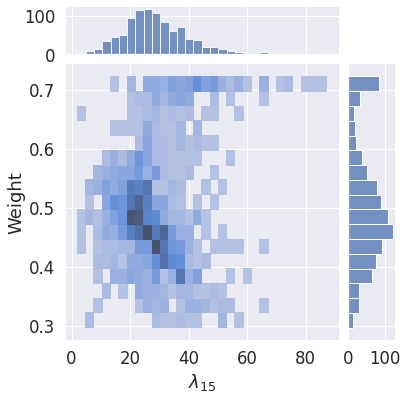

In [11]:
sns.set(font_scale=1.5)
#sns.set()
g = sns.JointGrid(data = df, x = r'$\lambda_{15}$', y = 'Weight', marginal_ticks = True)
 
g.plot(sns.histplot, sns.histplot)

bins = 15

labda_bins = (max(riches)-min(riches))/bins
weight_bins = (max(probs)-min(probs))/bins
#sns.displot(df, x = r'$\lambda_{15}$', y = 'Weight', binwidth=(labda_bins, weight_bins), cbar=True)
#sns.displot(df, x = r'$\lambda_{15}$', y = 'Weight', cbar=True)



<Figure size 324.445x324.445 with 0 Axes>

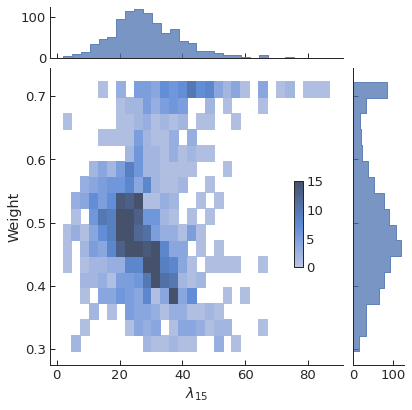

In [15]:
import matplotlib
matplotlib.rc('font',**{'family':'serif','sans-serif':['Times'],'size':11})
#matplotlib.rc('text',usetex=True)

#from matplotlib import gridspec
#import matplotlib.cm as cm
#import matplotlib.colors as colors
#import matplotlib.pyplot as plt
#plt.rc('text.latex', preamble=r'\usepackage{newtxtext}')
#plt.rc('text.latex', preamble=r'\usepackage{newtxmath}')
plt.rc('font',family='serif',size=11)
#plt.rc('text',usetex=True)

fullpage = False

# ------------------------------------------------------------------------------------------

dpi = 72.27*390.00/504.00

factory = 0.50
factorx = 1.00 if fullpage else 0.50
figsize = (factorx*504.00/dpi,factory*504.00/dpi)

fig = plt.figure(figsize=figsize)


sns.set_style("ticks", {"xtick.direction": "in","ytick.direction": "in"})
sns.set_context("paper",font_scale=1.5)
g = sns.JointGrid(data = df, x = r'$\lambda_{15}$', y = 'Weight', marginal_ticks = True)

# Create an inset legend for the histogram colorbar
cax = g.fig.add_axes([.7, .35, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, #discrete=(True, False),
    #cmap="light:#03012d", 
    pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step")#, color="#03012d")

plt.savefig('./plots/weights/weights_rich_hist.pdf')
plt.savefig('./plots/weights/weights_rich_hist.png', dpi = 300)
plt.show()
plt.close()

# Get compton y corrections

In [73]:
act_nvss = [6.1, 0.4]*u.mJy
mdcw_nvss = [3.9, 0.4]*u.mJy

alpha = [-0.91, 0.74]
act_c0 = act_nvss/(1.4)**alpha[0]
mdcw_c0 = mdcw_nvss/(1.4)**alpha[0]

act_90, act_150  = act_c0*90**alpha[0], act_c0*150**alpha[0]
act_90, act_150 = act_90.to(u.Jy), act_150.to(u.Jy)

mdcw_90, mdcw_150  = mdcw_c0*90**alpha[0], mdcw_c0*150**alpha[0]
mdcw_90, mdcw_150 = mdcw_90.to(u.Jy), mdcw_150.to(u.Jy)

act_90_beam, act_150_beam = np.pi*(2.2*u.arcmin/2)**2/np.log(2), np.pi*(1.4*u.arcmin/2)**2/np.log(2)
act_90_beam, act_150_beam = act_90_beam.to(u.sr), act_150_beam.to(u.sr)


act_90_y, act_150_y = jybeam2y(9.80E+10, act_90, act_90_beam), jybeam2y(1.50E+11, act_150, act_150_beam)
#Note everything here is with the ACT beam
mdcw_90_y, mdcw_150_y = jybeam2y(9.80E+10, mdcw_90, act_90_beam), jybeam2y(1.50E+11, mdcw_150, act_150_beam)
print(act_90_y, act_150_y)
print(mdcw_90_y, mdcw_150_y)
from astropy.cosmology import FlatLambdaCDM

from astropy.cosmology import Planck15 as cosmo

y_ref = 4.95e-5*(2/3)**1.08*cosmo.efunc(1)
print(act_90, act_150)
print(mdcw_90, mdcw_150)

[-3.08658929e-07 -2.02399298e-08] Jy / sr [-4.45651669e-07 -2.92230603e-08] Jy / sr
[-1.97339315e-07 -2.02399298e-08] Jy / sr [-2.84924838e-07 -2.92230603e-08] Jy / sr
[1.38021157e-04 9.05056768e-06] Jy [8.67088251e-05 5.68582460e-06] Jy
[8.82430348e-05 9.05056768e-06] Jy [5.54367898e-05 5.68582460e-06] Jy


In [74]:
print(act_90_y[0]/y_ref*100, act_90_y[1]/y_ref*100)
print(act_150_y[0]/y_ref*100, act_150_y[1]/y_ref*100)

print(mdcw_90_y[0]/y_ref*100, mdcw_90_y[1]/y_ref*100)
print(mdcw_150_y[0]/y_ref*100, mdcw_150_y[1]/y_ref*100)

-0.7337186078325864 Jy / sr -0.048112695595579444 Jy / sr
-1.0593664775313287 Jy / sr -0.06946665426434943 Jy / sr
-0.46909878205689953 Jy / sr -0.048112695595579444 Jy / sr
-0.677299879077407 Jy / sr -0.06946665426434943 Jy / sr


In [86]:
#95th percentile corrections
act_nvss = [20, 0.4]*u.mJy
mdcw_nvss = [10.87325, 0.4]*u.mJy

alpha = [-0.91, 0.74]
act_c0 = act_nvss/(1.4)**alpha[0]
mdcw_c0 = mdcw_nvss/(1.4)**alpha[0]

act_90, act_150  = act_c0*90**alpha[0], act_c0*150**alpha[0]
act_90, act_150 = act_90.to(u.Jy), act_150.to(u.Jy)

mdcw_90, mdcw_150  = mdcw_c0*90**alpha[0], mdcw_c0*150**alpha[0]
mdcw_90, mdcw_150 = mdcw_90.to(u.Jy), mdcw_150.to(u.Jy)

act_90_beam, act_150_beam = np.pi*(2.2*u.arcmin/2)**2/np.log(2), np.pi*(1.4*u.arcmin/2)**2/np.log(2)
act_90_beam, act_150_beam = act_90_beam.to(u.sr), act_150_beam.to(u.sr)


act_90_y, act_150_y = jybeam2y(9.80E+10, act_90, act_90_beam), jybeam2y(1.50E+11, act_150, act_150_beam)
#Note everything here is with the ACT beam
mdcw_90_y, mdcw_150_y = jybeam2y(9.80E+10, mdcw_90, act_90_beam), jybeam2y(1.50E+11, mdcw_150, act_150_beam)
y_ref = 4.95e-5*(2/3)**1.08*cosmo.efunc(1)

print(act_90_y[0]/y_ref*100, act_90_y[1]/y_ref*100)
print(act_150_y[0]/y_ref*100, act_150_y[1]/y_ref*100)

print(mdcw_90_y[0]/y_ref*100, mdcw_90_y[1]/y_ref*100)
print(mdcw_150_y[0]/y_ref*100, mdcw_150_y[1]/y_ref*100)

-1.7810005825293296 Jy / sr -0.035620011650586605 Jy / sr
-2.5714658091727705 Jy / sr -0.05142931618345542 Jy / sr
-0.9682632291993518 Jy / sr -0.035620011650586605 Jy / sr
-1.3980095304793918 Jy / sr -0.05142931618345542 Jy / sr


In [78]:
#J2247+0507 percentile corrections
act_nvss = [161, 0.4]*u.mJy
mdcw_nvss = [10.87325, 0.4]*u.mJy

alpha = [-0.61, 0.74]
act_c0 = act_nvss/(1.4)**alpha[0]
mdcw_c0 = mdcw_nvss/(1.4)**alpha[0]

act_90, act_150  = act_c0*90**alpha[0], act_c0*150**alpha[0]
act_90, act_150 = act_90.to(u.Jy), act_150.to(u.Jy)

mdcw_90, mdcw_150  = mdcw_c0*90**alpha[0], mdcw_c0*150**alpha[0]
mdcw_90, mdcw_150 = mdcw_90.to(u.Jy), mdcw_150.to(u.Jy)

act_90_beam, act_150_beam = np.pi*(2.2*u.arcmin/2)**2/np.log(2), np.pi*(1.4*u.arcmin/2)**2/np.log(2)
act_90_beam, act_150_beam = act_90_beam.to(u.sr), act_150_beam.to(u.sr)


act_90_y, act_150_y = jybeam2y(9.80E+10, act_90, act_90_beam), jybeam2y(1.50E+11, act_150, act_150_beam)
#Note everything here is with the ACT beam
mdcw_90_y, mdcw_150_y = jybeam2y(9.80E+10, mdcw_90, act_90_beam), jybeam2y(1.50E+11, mdcw_150, act_150_beam)
y_ref = 4.95e-5*(1.7/3)**1.08*cosmo.efunc(1)
print(act_90_y[0]/y_ref*100, act_90_y[1]/y_ref*100)
print(act_150_y[0]/y_ref*100, act_150_y[1]/y_ref*100)

print(mdcw_90_y[0]/y_ref*100, mdcw_90_y[1]/y_ref*100)
print(mdcw_150_y[0]/y_ref*100, mdcw_150_y[1]/y_ref*100)

-59.58292839935493 Jy / sr -0.14803212024684456 Jy / sr
-100.27511340661984 Jy / sr -0.249130716538186 Jy / sr
-4.023975628685007 Jy / sr -0.14803212024684456 Jy / sr
-6.772151408997076 Jy / sr -0.249130716538186 Jy / sr


In [61]:
#IR Corrections

ir_90 = [6.10490144495243e-05, 3.194603070168758e-06]
ir_150 = [0.0004094047628956179, 6.059812625094387e-05]

ir_mdcw_90_y, ir_mdcw_150_y = jybeam2y(9.80E+10, ir_90, act_90_beam), jybeam2y(1.50E+11, ir_150, act_150_beam)

print(ir_mdcw_90_y[0]/y_ref*100, ir_mdcw_90_y[1]/y_ref*100)
print(ir_mdcw_150_y[0]/y_ref*100, ir_mdcw_150_y[1]/y_ref*100)

-0.24026853161802603 1 / sr -0.012572890745132513 1 / sr
-3.703140438637672 1 / sr -0.5481210580902677 1 / sr


In [ ]:
%reset -f